In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50  import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop 


2022-11-30 13:30:30.189270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-11-30 13:30:37.421647: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-30 13:30:37.423507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-30 13:30:37.430031: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-11-30 13:30:37.430063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lnx00273.ad.liu.se
2022-11-30 13:30:37.430071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lnx00273.ad.liu.se
2022-11-30 13:30:37.430142: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2022-11-30 13:30:37.430176: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.

IndexError: list index out of range

In [3]:
datagenerator = ImageDataGenerator()

In [4]:
datagenerator = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale= 1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    brightness_range=[0.80,1.20],
    fill_mode='nearest'    
)

In [5]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('../train/', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=False,
    color_mode='rgb')

# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('../valid/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False,
    color_mode='rgb')

# load and iterate test dataset
test_data = datagenerator.flow_from_directory('../test/', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False,
    color_mode='rgb')

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


In [6]:
train_data.class_indices

{'aff': 0, 'control': 1}

The dimensions of the image are 224 pixels width and 224 pixels height, three channels.
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.3282 and the standard deviation is 0.3283


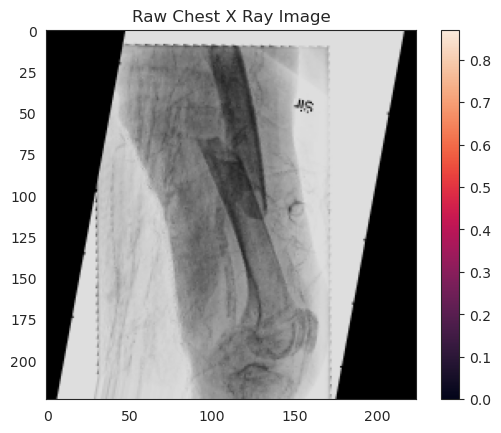

In [7]:
sns.set_style('white')
generated_image, label = train_data.__getitem__(0)
plt.imshow(generated_image[13])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, three channels.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [8]:
generated_image.shape

(32, 224, 224, 3)

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 256x256 with 3 bytes color

    # The first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    
    # add a dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.4),

    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(256, activation='relu'),
    
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2022-11-30 13:31:32.002536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 13:31:32.002948: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0

In [11]:
model.compile(loss='binary_crossentropy', optimizer= RMSprop(learning_rate=0.001), metrics=['acc'])

In [12]:
n_epochs = 20
batch_size = 64

In [13]:
total_sample=train_data.n

In [14]:
from sklearn.utils import class_weight

In [15]:
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))

In [16]:
weights

array([2.5  , 0.625])

In [17]:
dict_weights = {0: weights[0], 1:weights[1]}

In [18]:
dict_weights

{0: 2.5, 1: 0.625}

In [19]:
history = model.fit( train_data, validation_data= val_data, epochs=n_epochs, verbose=1, class_weight=dict_weights)

2022-11-30 13:31:39.422414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-30 13:31:39.422903: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3491940000 Hz


Epoch 1/20


2022-11-30 13:31:44.950640: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 201867264 exceeds 10% of free system memory.


 1/82 [..............................] - ETA: 8:22 - loss: 0.4017 - acc: 0.9062

2022-11-30 13:31:45.444039: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 201867264 exceeds 10% of free system memory.
2022-11-30 13:31:49.166718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 201867264 exceeds 10% of free system memory.
2022-11-30 13:31:49.607024: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 201867264 exceeds 10% of free system memory.


 2/82 [..............................] - ETA: 5:35 - loss: 0.3039 - acc: 0.9297

2022-11-30 13:31:52.933895: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 201867264 exceeds 10% of free system memory.


82/82 [==============================] - 460s 6s/step - loss: 3.0211 - acc: 0.5738 - val_loss: 0.6886 - val_acc: 0.7989
Epoch 2/20
82/82 [==============================] - 450s 6s/step - loss: 0.8138 - acc: 0.7949 - val_loss: 0.6983 - val_acc: 0.2011
Epoch 3/20
82/82 [==============================] - 451s 6s/step - loss: 0.9563 - acc: 0.7285 - val_loss: 0.7105 - val_acc: 0.2011
Epoch 4/20
82/82 [==============================] - 449s 5s/step - loss: 0.8221 - acc: 0.5097 - val_loss: 0.7056 - val_acc: 0.2011
Epoch 5/20
82/82 [==============================] - 450s 6s/step - loss: 0.7112 - acc: 0.4213 - val_loss: 0.6924 - val_acc: 0.7989
Epoch 6/20
82/82 [==============================] - 448s 5s/step - loss: 0.8594 - acc: 0.4319 - val_loss: 0.6780 - val_acc: 0.7989
Epoch 7/20
82/82 [==============================] - 451s 6s/step - loss: 0.8738 - acc: 0.4318 - val_loss: 0.6914 - val_acc: 0.4759
Epoch 8/20
82/82 [==============================] - 448s 6s/step - loss: 0.7088 - acc: 0.5455 

In [ ]:
model.evaluate_generator(test_data)

/home/chash345/.conda/envs/research/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.5343754291534424, 0.7997685074806213]

: 

So we have AFF accuracy of 54% and control accuracy of 80%

### Using transfer learning

In [ ]:
pre_trained_model = ResNet50(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

: 

In [ ]:
pre_trained_model = ResNet50(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

tf.random.set_seed(21)

model = tf.keras.models.Sequential([
    pre_trained_model,
    GlobalAveragePooling2D(),    
    Dense(512,activation="swish"),
    Dropout(0.5),
    Dense(256,activation="swish"),
    Dropout(0.5),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

: 

In [ ]:
history = model.fit(
    train_data,
    steps_per_epoch=40,
    epochs=2,
    validation_data=val_data,  
)

Epoch 1/2
40/40 [==============================] - 674s 17s/step - loss: 0.6869 - accuracy: 0.7224 - val_loss: 0.6696 - val_accuracy: 0.7989
Epoch 2/2
40/40 [==============================] - 430s 11s/step - loss: 0.6584 - accuracy: 0.8466 - val_loss: 0.6429 - val_accuracy: 0.7989


: 

In [ ]:
model.evaluate(test_data)

14/14 [==============================] - 197s 15s/step - loss: 0.6428 - accuracy: 0.7998


[0.6427768468856812, 0.7997685074806213]

: 

Accuracy jumped 10% for aff class. Need to try more!